In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from rasterstats import zonal_stats
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import box


# 1. Data Preperation

In [2]:
#Load pre-existing park data
parks_gdf = gpd.read_file('Data/Riyadh_parks_stats_2024.geojson')
print("Loaded parks_gdf with columns:", parks_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'geometry'],
      dtype='object')


In [3]:
# File link: https://drive.google.com/file/d/1OCiJFoE-HmlpSLjt37WhoBhgVWdKSz0W/view?usp=sharing
# Then it should be added to a folder called Raster within the Data folder

# Define LST file path
lst_2024_path = 'Data/Raster/Riyadh_LST_EPSG20438_2024.tif' 


In [4]:
# Open LST raster to access pixel values and transformation parameters.
with rasterio.open(lst_2024_path) as lst_src:
    lst_transform = lst_src.transform
    lst_crs = lst_src.crs
    lst_data = lst_src.read(1)
   # print(np.nanmin(lst_data), np.nanmax(lst_data))

# 2. Buffer Creation

For each park, createt buffers at 30m intervals up to 300m for the comparison of LST across different zones, providing insights into the urban heat island effect and park cooling influence. ([Cai et al., 2023](https://www.researchgate.net/publication/374556563_Cooling_island_effect_in_urban_parks_from_the_perspective_of_internal_park_landscape); [Zhang et al., 2024](https://www.nature.com/articles/s41598-024-67277-2))


In [5]:
# 2. Generate Buffers (30m intervals up to 300m)
buffer_distances = range(30, 301, 30)  # [30, 60, 90,..., 300]

# Initialize buffer_gdf with a sample row to set dtypes, ensuring Park_id as int
# and to avoid warning i got:  The behavior of DataFrame concatenation with empty or all-NA entries is deprecated
initial_row = {'Park_id': 0, 'distance': 0, 'geometry': Polygon()}
buffer_gdf = gpd.GeoDataFrame([initial_row], crs=parks_gdf.crs)
buffer_gdf = buffer_gdf.iloc[0:0]  # Clear the initial row, keeping dtypes


for park_id, park in parks_gdf.iterrows():
    for dist in buffer_distances:
        # Create donut-shaped buffers (outer - inner)
        outer = park.geometry.buffer(dist)
        inner = park.geometry.buffer(max(0, dist-30))  # Handle 0-30m case
        ring = outer.difference(inner)
        
        # Append to GeoDataFrame
        buffer_gdf = pd.concat([
            buffer_gdf,
            gpd.GeoDataFrame({
                'Park_id': [int(park['Park_id'])],  # Use actual Park_id for accurate mapping
                'distance': [dist],
                'geometry': [ring]
            }, crs=parks_gdf.crs)
        ], ignore_index=True)


In [6]:
# Verify the output structure
print(f"Generated {len(buffer_gdf)} buffer rings")
print("GeoDataFrame columns:", buffer_gdf.columns)
print("CRS:", buffer_gdf.crs)
print("Sample data:")
print(buffer_gdf.head(3))

Generated 2210 buffer rings
GeoDataFrame columns: Index(['Park_id', 'distance', 'geometry'], dtype='object')
CRS: EPSG:20438
Sample data:
   Park_id  distance                                           geometry
0        1        30  POLYGON ((678371.261 2735243.793, 678368.638 2...
1        1        60  POLYGON ((678387.297 2735218.438, 678382.05 27...
2        1        90  POLYGON ((678403.333 2735193.084, 678395.463 2...


In [7]:
# # Save to GeoJSON
# ## Commented out as it's needed once
# buffer_gdf.to_file('Data/Riyadh_parks_buffers.geojson', driver='GeoJSON')
# print("Saved buffers to GeoJSON")

# 3. LST Mean Calculation

Here, the pixel-polygon overlap appraoch is used for mean calculation. Check Section 2.2 of '04_FactorsCalculations.ipynb' for justification.

In [8]:
# Initialize buffer columns for LST means and pixel counts in parks_gdf (park interiors) and buffer_gdf (buffer zones)
for dist in range(30, 301, 30):
    parks_gdf[f'lst_buffer_{dist}m'] = np.nan

parks_gdf['lst_park'] = np.nan
parks_gdf['park_pixel_count'] = 0
buffer_gdf['lst_mean'] = np.nan
buffer_gdf['pixel_count'] = 0


### 2.1 Calculate Mean LST within each park

In [9]:
# Calculate LST for park interiors manually with fractional overlap
# Followin NDVI manual method for consistency, weighting pixels >50% within park
with rasterio.open(lst_2024_path) as lst_src:
    # Get raster properties for overlap calculation
    pixel_area = abs(lst_src.transform[0] * lst_src.transform[4])  # 30m x 30m = 900 m²
    threshold_area = 0.50 * pixel_area  # 50% threshold, 450 m²
    raster_nodata = lst_src.nodata if lst_src.nodata is not None else -999

    for idx, park in parks_gdf.iterrows():
        geom = park.geometry
        if not geom.is_valid:
            geom = geom.buffer(0)
            print(f"Repaired invalid geometry for park {park['Park_id']}")

        # Rasterize park mask with all_touched
        mask = rasterio.features.rasterize(
            [(geom, 1)],
            out_shape=(lst_src.height, lst_src.width),
            transform=lst_src.transform,
            fill=0,
            default_value=1,
            all_touched=True
        ) == 1

        # Extract and weight LST values
        lst_park_data = lst_src.read(1)
        y_indices, x_indices = np.where(mask)
        total_weighted_sum = 0
        total_weighted_area = 0

        for y, x in zip(y_indices, x_indices):
            pixel_geom = box(
                lst_src.transform[2] + x * lst_src.transform[0],  # minx
                lst_src.transform[5] + y * lst_src.transform[4],  # miny
                lst_src.transform[2] + (x + 1) * lst_src.transform[0],  # maxx
                lst_src.transform[5] + (y + 1) * lst_src.transform[4]  # maxy
            )
            intersection = geom.intersection(pixel_geom)
            if not intersection.is_empty:
                overlap_area = intersection.area
                if overlap_area >= threshold_area:  # Only include >50% overlap
                    lst_value = lst_park_data[y, x]
                    if lst_value != raster_nodata:
                        total_weighted_sum += lst_value * overlap_area
                        total_weighted_area += overlap_area
                        parks_gdf.at[idx, 'park_pixel_count'] += 1

        # Calculate weighted mean for park interior
        if total_weighted_area > 0:
            parks_gdf.at[idx, 'lst_park'] = total_weighted_sum / total_weighted_area
        else:
            print(f"Park {park['Park_id']} has no valid overlapping pixels.")

Repaired invalid geometry for park 155.0


### 2.2 Calculate Mean LST within each buffer zone for each park

In [10]:
# Calculate LST for buffer zones manually with fractional overlap
# Mirrors NDVI approach, ensuring consistent weighting across buffer distances
with rasterio.open(lst_2024_path) as lst_src:
    # Reuse raster properties for buffer calculations
    pixel_area = abs(lst_src.transform[0] * lst_src.transform[4])  # 30m x 30m = 900 m²
    threshold_area = 0.50 * pixel_area  # 50% threshold, 450 m²
    raster_nodata = lst_src.nodata if lst_src.nodata is not None else -999

    for idx, buffer in buffer_gdf.iterrows():
        geom = buffer.geometry
        park_id = buffer['Park_id']
        dist = buffer['distance']

        if not geom.is_valid:
            geom = geom.buffer(0)
            print(f"Repaired invalid geometry for buffer of park {park_id} at {dist}m")

        # Rasterize buffer mask with all_touched
        mask = rasterio.features.rasterize(
            [(geom, 1)],
            out_shape=(lst_src.height, lst_src.width),
            transform=lst_src.transform,
            fill=0,
            default_value=1,
            all_touched=True
        ) == 1

        # Extract and weight LST values for buffer
        lst_buffer_data = lst_src.read(1)
        y_indices, x_indices = np.where(mask)
        total_weighted_sum = 0
        total_weighted_area = 0

        for y, x in zip(y_indices, x_indices):
            pixel_geom = box(
                lst_src.transform[2] + x * lst_src.transform[0],  # minx
                lst_src.transform[5] + y * lst_src.transform[4],  # miny
                lst_src.transform[2] + (x + 1) * lst_src.transform[0],  # maxx
                lst_src.transform[5] + (y + 1) * lst_src.transform[4]  # maxy
            )
            intersection = geom.intersection(pixel_geom)
            if not intersection.is_empty:
                overlap_area = intersection.area
                if overlap_area >= threshold_area:  # Only include >50% overlap
                    lst_value = lst_buffer_data[y, x]
                    if lst_value != raster_nodata:
                        total_weighted_sum += lst_value * overlap_area
                        total_weighted_area += overlap_area
                        buffer_gdf.at[idx, 'pixel_count'] += 1

        # Calculate weighted mean for buffer zone
        if total_weighted_area > 0:
            buffer_gdf.at[idx, 'lst_mean'] = total_weighted_sum / total_weighted_area
        else:
            print(f"Buffer for park {park_id} at {dist}m has no valid overlapping pixels.")

### 2.3 Appending results to parks_gdf

**Note:** lst_park (interior LST) is calculated and added separately in sec 2.1

In [11]:
# Adding LST buffer values to parks_gdf
for park_id in parks_gdf['Park_id'].unique():
    park_buffers = buffer_gdf[buffer_gdf['Park_id'] == park_id]
    for _, buffer in park_buffers.iterrows():
        dist = buffer['distance']
        lst_value = buffer['lst_mean']
        if lst_value is not None and not np.isnan(lst_value):
            parks_gdf.loc[parks_gdf['Park_id'] == park_id, f'lst_buffer_{dist}m'] = lst_value

print("Processing complete. Results include:")
print(f"- {len(parks_gdf)} parks processed")
print(f"- Cooling effects calculated for buffers 30-300m")

Processing complete. Results include:
- 221 parks processed
- Cooling effects calculated for buffers 30-300m


In [12]:
print(f"- Number of parks with valid lst_park: {parks_gdf['lst_park'].notna().sum()} ({parks_gdf['park_pixel_count'].sum()} pixels)")
print(f"- Number of buffers with valid lst_mean: {buffer_gdf['lst_mean'].notna().sum()} ({buffer_gdf['pixel_count'].sum()} pixels)")

- Number of parks with valid lst_park: 221 (3304 pixels)
- Number of buffers with valid lst_mean: 2210 (98870 pixels)


# 4. Cooling Parameter Identification

### 4.1 Cubic Curve Fitting

To be able to calculate different cooling metrics, a cubic polynomial function  was fitted to the average LST across buffers as per the equation below:


$$T(r) = a r^3 + b r^2 + c r + d$$

 Where:
  - r: Distance from the park boundary (in meters, from 0m inside the park to 300m outside).
  - a : Coefficient of the cubic term, controlling the steepness of the inflection point.
  - b : Coefficient of the quadratic term, shaping the curve’s curvature.
  - c : Coefficient of the linear term, determining the initial slope.
  - d : Constant term, approximating the LST at $ r = 0 $


Aligned wih: 
([Peng et al., 2021](https://www.sciencedirect.com/science/article/pii/S0034425720305083#bb0110); [Pan et al., 2025](https://www.sciencedirect.com/science/article/pii/S2210670725004913))

In [13]:
# Prepare LST data for cubic fitting
# Extracts LST values and distances for each park, ensuring no NaN values disrupt the fit
parks_gdf['lst_data'] = None  # Temporary column to store LST arrays
distances = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300])  # Aligns with buffer intervals

for idx, park in parks_gdf.iterrows():
    lst_values = [park['lst_park']] + [park[f'lst_buffer_{d}m'] for d in range(30, 301, 30)]
    if all(not np.isnan(val) for val in lst_values):  # Check for complete data
        parks_gdf.at[idx, 'lst_data'] = np.array(lst_values)
    else:
        print(f"Park {park['Park_id']} has missing LST data, skipping cubic fit.")

In [14]:
# Perform cubic curve fitting for each park
# Fits a cubic polynomial T(r) = a r^3 + b r^2 + c r + d to LST vs. distance data
parks_gdf['cubic_coeffs'] = None  # Store coefficients [a, b, c, d]
parks_gdf['r_squared'] = np.nan  # Store goodness-of-fit

for idx, park in parks_gdf.iterrows():
    lst_values = park['lst_data']
    if lst_values is not None:
        # Fit cubic polynomial using polyfit
        coefficients = np.polyfit(distances, lst_values, 3)  # Returns [a, b, c, d]
        polynomial = np.poly1d(coefficients)
        # Calculate R²
        residuals = lst_values - polynomial(distances)
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((lst_values - np.mean(lst_values)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
        # Store results
        parks_gdf.at[idx, 'cubic_coeffs'] = coefficients
        parks_gdf.at[idx, 'r_squared'] = r_squared
        print(f"Park {park['Park_id']}: Fitted with R² = {r_squared:.3f}, Coefficients = {coefficients}")
    else:
        print(f"Park {park['Park_id']}: Skipping due to missing data")

Park 1.0: Fitted with R² = 0.988, Coefficients = [ 6.51124249e-08 -3.95183559e-05  9.96542156e-03  4.97257872e+01]
Park 2.0: Fitted with R² = 0.235, Coefficients = [ 1.00630022e-08 -2.02962650e-06 -1.93438008e-04  5.02484550e+01]
Park 3.0: Fitted with R² = 0.994, Coefficients = [-2.55926599e-08  6.23103044e-06  5.77842023e-03  4.98262410e+01]
Park 4.0: Fitted with R² = 0.915, Coefficients = [-8.12971830e-08  6.65225282e-05 -1.29569942e-02  5.14153863e+01]
Park 5.0: Fitted with R² = 0.971, Coefficients = [-3.17476515e-08 -4.48452213e-07  5.45928860e-03  4.98616713e+01]
Park 6.0: Fitted with R² = 0.986, Coefficients = [ 1.45602526e-08  1.41422217e-05 -8.21523117e-03  5.15153943e+01]
Park 7.0: Fitted with R² = 0.906, Coefficients = [-9.58405180e-08  2.53660627e-05  2.34633284e-03  5.05296748e+01]
Park 8.0: Fitted with R² = 0.992, Coefficients = [-1.20571167e-07  4.34280399e-05  2.14968080e-03  5.07258133e+01]
Park 9.0: Fitted with R² = 0.994, Coefficients = [ 2.52128062e-08  9.92189196e-0

### 4.2 Turning Point and Metric Calculation

This section identifies the park cooling distance (PCD) and calculates key cooling metrics based on the fitted cubic polynomial $T(r)$. The PCD is determined as the distance where the first derivative \( T'(r) \) reaches its minimum value within the buffer range (30–300m), representing the point of maximum cooling influence or stabilization. If there is no turning point, the minimum value of the first derivative of the $ T(r) $ function will be used to represent the turning point, aligning with litrature ([Peng et al, 2021](https://www.sciencedirect.com/science/article/pii/S0034425720305083#s0010); [Zhang et al., 2024](https://www.nature.com/articles/s41598-024-67277-2))


 The following metrics are derived to evaluate the cooling effect:

- **Park Cooling Distance (PCD)**: The distance from the park boundary where the LST increase rate is minimized, in meters, indicating the spatial extent of cooling influence.

- **Park Cooling Intensity (PCI)**: The temperature difference between the LST at the first turning point (PCD) and the average LST within the park.
$$PCI = T(PCD) - lst_{park}$$

- **Park Cooling Area (PCA)**:  The maximum influence range of the cooling effect of parks, which is determined by the PCD.
$$PCA = Area {PCD buffer}$$

- **Park Cooling Efficiency (PCE)**: The ratio of PCA to the park’s area.
$$PCE = \frac{PCA}{park_{area}}$$


Equations adopted from:
[Peng et al, 2021](https://www.sciencedirect.com/science/article/pii/S0034425720305083#s0010); [Cai et al., 2023](https://www.researchgate.net/publication/374556563_Cooling_island_effect_in_urban_parks_from_the_perspective_of_internal_park_landscape)

In [15]:
# Identify turning point and calculate cooling parameters
# Uses the minimum value of the first derivative T'(r) as PCD if no root exists, per [Peng et al., 2021; Zhang et al., 2024 ]

parks_gdf['PCD'] = np.nan
parks_gdf['PCI'] = np.nan
parks_gdf['PCA'] = np.nan
parks_gdf['PCE'] = np.nan  

for idx, park in parks_gdf.iterrows():
    coefficients = park['cubic_coeffs']
    if coefficients is not None:
        polynomial = np.poly1d(coefficients)
        # First derivative
        derivative = np.polyder(polynomial)
        # Evaluate derivative at discrete distances (exclude 0m 0m to ensure PCD is a buffer distance)
        deriv_values = derivative(distances[1:])  # Start from 30m
        buffer_distances = distances[1:]  # Align distances with derivative values
        # Find the index of the minimum derivative value within 30-300m
        valid_deriv = deriv_values[~np.isnan(deriv_values)]  # Exclude NaN if any
        if len(valid_deriv) > 0:
            min_deriv_idx = np.argmin(np.abs(valid_deriv))  # Index of minimum derivative
            pcd = buffer_distances[min_deriv_idx]  # Corresponding distance as PCD
        else:
            pcd = 300.0  # Fallback to maximum distance if all invalid
            print(f"Park {park['Park_id']}: No valid derivative values, using 300m as PCD")
        pci = polynomial(pcd) - park['lst_park']  # PCI = T(PCD) - lst_park
        # Find the buffer_gdf row for this park and PCD distance
        buffer_row = buffer_gdf[(buffer_gdf['Park_id'] == park['Park_id']) & (buffer_gdf['distance'] == pcd)]
        if not buffer_row.empty:
            pca = buffer_row['geometry'].area.iloc[0]  # PCA as buffer area at PCD
            pce = pca / park['area_m2']  # PCE as ratio of PCA to park area
        else:
            pca = 0  # Default to 0 if no exact match
            pce = 0  # Default PCE to 0 if PCA is 0
            print(f"Park {park['Park_id']}: No exact buffer at PCD {pcd}m, PCA and PCE set to 0")
        parks_gdf.at[idx, 'PCD'] = pcd
        parks_gdf.at[idx, 'PCI'] = pci
        parks_gdf.at[idx, 'PCA'] = pca
        parks_gdf.at[idx, 'PCE'] = pce
        print(f"Park {park['Park_id']}: PCD = {pcd:.1f}m, PCI = {pci:.2f}°C, PCA = {pca:.2f}m², PCE = {pce:.2f}")
    else:
        print(f"Park {park['Park_id']}: Skipping due to missing coefficients")

Park 1.0: PCD = 210.0m, PCI = 0.99°C, PCA = 50387.39m², PCE = 5.00
Park 2.0: PCD = 180.0m, PCI = 0.00°C, PCA = 42446.27m², PCE = 4.77
Park 3.0: PCD = 300.0m, PCI = 1.57°C, PCA = 64685.05m², PCE = 8.50
Park 4.0: PCD = 120.0m, PCI = -0.64°C, PCA = 27127.92m², PCE = 7.31
Park 5.0: PCD = 240.0m, PCI = 0.80°C, PCA = 47920.21m², PCE = 24.08
Park 6.0: PCD = 210.0m, PCI = -0.92°C, PCA = 43163.33m², PCE = 15.06
Park 7.0: PCD = 210.0m, PCI = 0.66°C, PCA = 47632.04m², PCE = 5.74
Park 8.0: PCD = 270.0m, PCI = 1.43°C, PCA = 61019.81m², PCE = 5.13
Park 9.0: PCD = 210.0m, PCI = -0.96°C, PCA = 47686.02m², PCE = 5.69
Park 10.0: PCD = 150.0m, PCI = -0.06°C, PCA = 32802.10m², PCE = 8.64
Park 11.0: PCD = 240.0m, PCI = 0.84°C, PCA = 53551.57m², PCE = 6.91
Park 12.0: PCD = 270.0m, PCI = 0.43°C, PCA = 55893.84m², PCE = 12.94
Park 13.0: PCD = 60.0m, PCI = -0.22°C, PCA = 21563.74m², PCE = 3.24
Park 14.0: PCD = 210.0m, PCI = 1.86°C, PCA = 51724.70m², PCE = 3.36
Park 15.0: PCD = 210.0m, PCI = 1.88°C, PCA = 59611

# 5. Results Exploration

In [30]:
# # Export redults for exploration in Qgis

# # Comment out export, only needed once:
# parks_gdf.to_file('Data/Riyadh_parks_with_LST.geojson', driver='GeoJSON')

In [23]:
# Calculate average R² from fitted curves
avg_r2 = np.nanmean(parks_gdf['r_squared'])
print(f"Average R² across all parks: {avg_r2:.3f}")

Average R² across all parks: 0.953


In [21]:

# Statistical summary
cooling_metrics = parks_gdf[['PCD', 'PCI', 'PCA', 'PCE']].describe()
print("\nStatistical Summary of Cooling Metrics")
print(cooling_metrics.round(2))

# Categorize cooling vs. heating parks
cooling_parks = parks_gdf[parks_gdf['PCI'] < 0].shape[0]
heating_parks = parks_gdf[parks_gdf['PCI'] >= 0].shape[0]
total_parks = len(parks_gdf)
print(f"\nCooling Parks (PCI < 0): {cooling_parks} ({cooling_parks/total_parks*100:.1f}%)")
print(f"Heating Parks (PCI >= 0): {heating_parks} ({heating_parks/total_parks*100:.1f}%)")




Statistical Summary of Cooling Metrics (excluding Park 2):
          PCD     PCI        PCA     PCE
count  221.00  221.00     221.00  221.00
mean   174.84    0.50   42123.99    9.13
std     81.80    0.98   19496.43    7.64
min     30.00   -1.95    6775.04    0.30
25%    120.00   -0.06   27525.19    3.85
50%    180.00    0.35   43163.33    6.78
75%    240.00    0.90   54515.31   11.84
max    300.00    7.45  133933.70   41.07

Cooling Parks (PCI < 0): 68 (30.8%)
Heating Parks (PCI >= 0): 153 (69.2%)


Visualizing the distribution of PCD, PCI, PCA, and PCE for parks with cooling effects (PCI < 0), highlighting variability and comparing with the mean

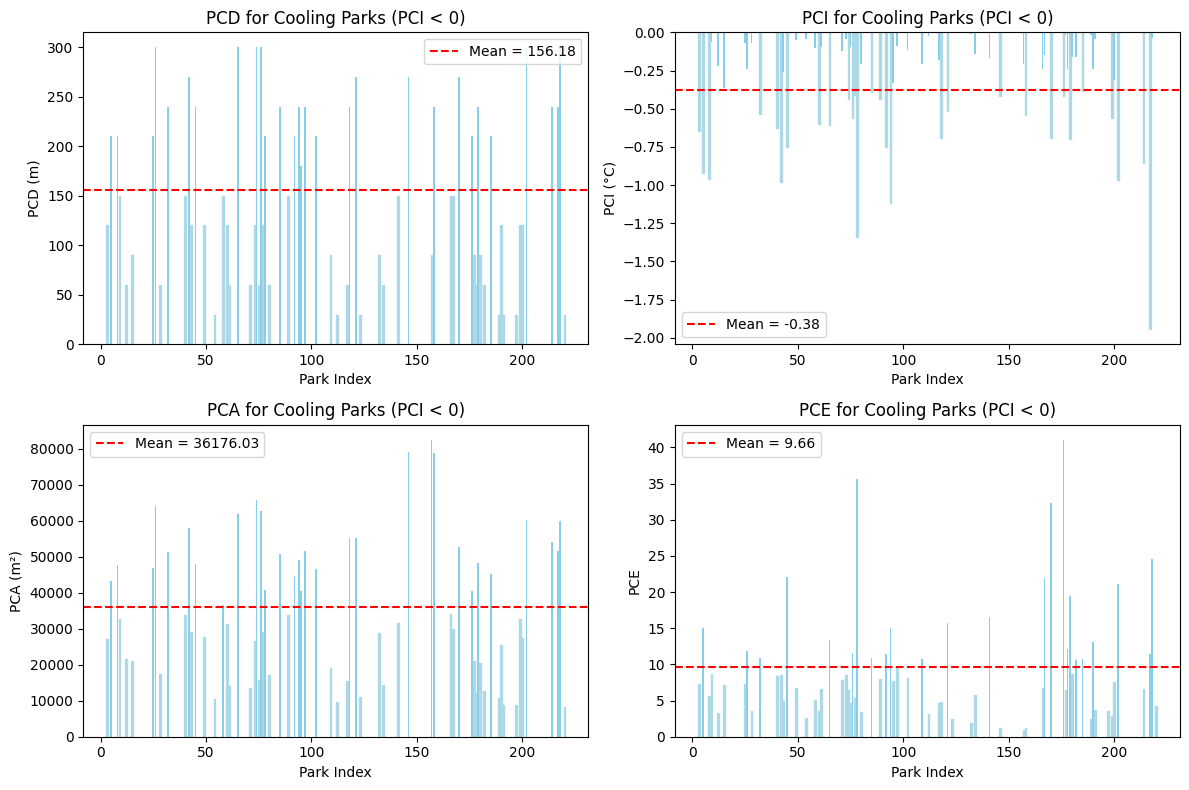

In [24]:
# Bar graphs for cooling parks
cooling_parks = parks_gdf[parks_gdf['PCI'] < 0]
metrics = ['PCD', 'PCI', 'PCA', 'PCE']
means = cooling_parks[metrics].mean()

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    plt.bar(cooling_parks.index, cooling_parks[metric], color='skyblue')
    plt.axhline(y=means[metric], color='r', linestyle='--', label=f'Mean = {means[metric]:.2f}')
    plt.title(f'{metric} for Cooling Parks (PCI < 0)')
    plt.xlabel('Park Index')
    plt.ylabel(metric + (' (m)' if metric == 'PCD' else ' (°C)' if metric == 'PCI' else ' (m²)' if metric == 'PCA' else ''))
    plt.legend()
    # Shade bars below mean
    for j, val in enumerate(cooling_parks[metric]):
        if val < means[metric]:
            plt.gca().patches[j].set_color('lightblue')
plt.tight_layout()
plt.show()

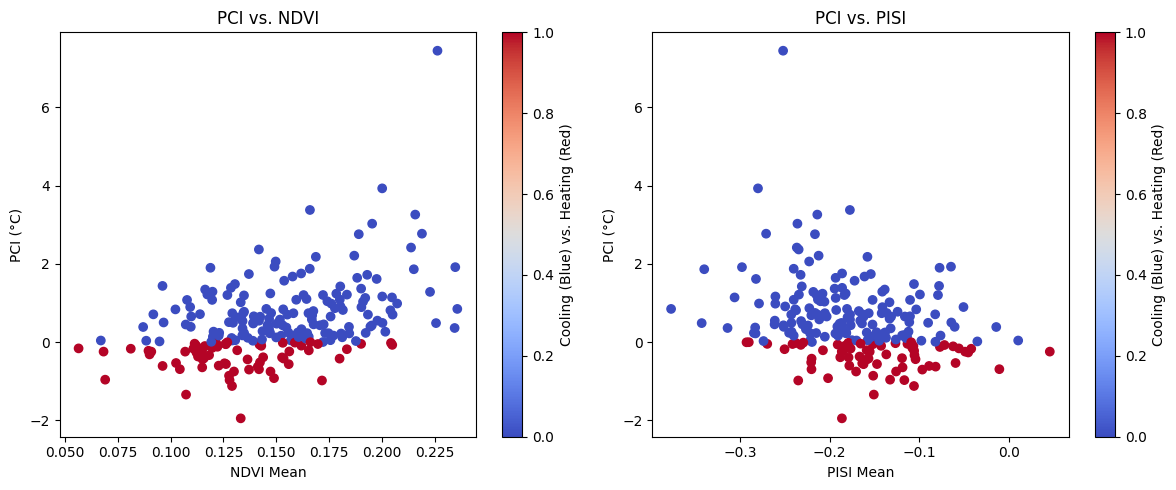

In [26]:
# Scatter plot of PCI vs. NDVI and PISI
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(parks_gdf['ndvi_mean'], parks_gdf['PCI'], c=parks_gdf['PCI'] < 0, cmap='coolwarm')
plt.title('PCI vs. NDVI')
plt.xlabel('NDVI Mean')
plt.ylabel('PCI (°C)')
plt.colorbar(label='Cooling (Blue) vs. Heating (Red)')
plt.subplot(1, 2, 2)
plt.scatter(parks_gdf['pisi_mean'], parks_gdf['PCI'], c=parks_gdf['PCI'] < 0, cmap='coolwarm')
plt.title('PCI vs. PISI')
plt.xlabel('PISI Mean')
plt.ylabel('PCI (°C)')
plt.colorbar(label='Cooling (Blue) vs. Heating (Red)')
plt.tight_layout()
plt.show()